# Data Exploration

This system processes raw CT scans (`.mhd` metadata and `.raw` voxel data, indexed by [DICOM](https://www.dicomstandard.org) series UID) and LUNA-provided nodule annotations to generate training samples.

The Ct class constructs a 3D voxel array and a transformation matrix for patient-to-voxel coordinate conversion (denoted as (I,R,C) in code). Annotations include nodule coordinates with malignancy labels, linked to corresponding CT scans via UID. Coordinate transformations map annotated nodules to their precise (I,R,C) voxel indices within the 3D array.

> **NOTE**: (I,R,C) stands for (Index, Row, Column)

We will also load the annotation data provided by LUNA, which will give us a list of nodule coordinates, each with a malignancy flag, along with the series `UID` of the relevant CT scan. By combining the nodule coordinate with coordinate system transformation information, we get the index, row, and column of the voxel at the center of our nodule.

## The task

Using the (I,R,C) coordinates, we can crop a small 3D slice of our CT data to use as the input to our model. Along with this 3D sample array, we must construct the rest of our training sample tuple, which will have the sample array, nodule status flag, series UID, and the index of this sample in the CT list of nodule candidates. This sample tuple is exactly what PyTorch expects from our Dataset subclass and represents the last section of our bridge from our original raw data to the standard structure of PyTorch tensors.


# Describing Data structures

The 10 subsets we discussed earlier have about 90 CT scans each (888 in total), with every CT scan represented as two files: one with a `.mhd` extension and one with a `.raw` extension. The data being split between multiple files is hidden behind the `sitk` routines, however, and is not something we need to be directly concerned with.

## Series UID

We identify specific CT scans using the **series instance UID** (**series_uid**) assigned when the CT scan was created. DICOM makes heavy use of unique identifiers (UIDs) for individual DICOM files, groups of files, courses of treatment, and so on.

`seriesuid` is property that is in both `candidates.csv` and `annotations.csv`. It uniquely identifies CT scan. But metadata assigned to this scans does not need to be unique. Both candidates and annotations dataframes are not unique on `seriesuid`. Candidates file contains center point of potential nodule and info if it is nodule or just lump. Annotation file contains center point of indemnified nodule and diameter of this nodule. CT scan can have multiple nodules and thus both of this dataframes can he multiple rows with the same `seriesuid`.

> **Series UID** identifiers are similar in concept to [UUIDs](https://docs.python.org/3/library/uuid.html), but they have a different creation process and are formatted differently. For our purposes, we can treat them as opaque ASCII strings that serve as unique keys to reference the various CT scans. Officially, only the characters $0$ through $9$ and the period (.) are valid characters in a DICOM UID, but some DICOM files in the wild have been anonymized with routines that replace the UIDs with hexadecimal (0–9 and a–f) or other technically out-of-spec values.


## CT Scan

### Dimensions

CTs are commonly $512$ rows by $512$ columns, with the index dimension ranging from around $100$ total slices up to perhaps $250$ slices ($250$ slices times $2.5$ millimeters is typically enough to contain the anatomical region of interest). This results in a lower bound of approximately $2^{25}$ voxels, or about $32$ million data points. Each CT specifies the voxel size in millimeters as part of the file metadata; for example, we’ll call `ct_mhd.GetSpacing()`.

### Units 

CT scan voxels are expressed in [Hounsfield units (HU)](https://en.wikipedia.org/wiki/Hounsfield_scale), which are odd units; air is $–1,000 \ HU$ (close enough to $0 \ g/cc$ [grams per cubic centimeter] for our purposes), water is $0 \ HU$ ($1 \ g/cc$), and bone is at least $+1,000 \ HU$ ($2–3 \ g/cc$).

Some CT scanners use HU values that correspond to negative densities to indicate that those voxels are outside of the CT scanner’s field of view. For our purposes, everything outside of the patient should be air, so we discard that field-of-view information by setting a lower bound of the values to $–1,000 \ HU$.

Similarly, the exact densities of bones, metal implants, and so on are not relevant to our use case, so we cap density at roughly $2 \ g/cc$ ($1,000 \ HU$) even though that’s not biologically accurate in most cases.


# Locating and Scaling nodules

Deep learning models typically need fixed-size inputs, due to having a fixed number of input neurons. We need to be able to produce a fixed-size array containing the candidate so that we can use it as input to our classifier. We’d like to train our model using a crop of the CT scan that has a candidate nicely centered.

## CT Scan vs. Candidates file coordination system


<figure>
    <center>
        <img src="attachments/millimeter-vs-voxels.png"  style="width:550px;" >
    </center>
</figure>

Unfortunately, all of the candidate center data we loaded expressed in **millimeters, not voxels**! We can’t just plug locations in millimeters into an array index and expect everything to work out the way we want. As we can see in figure above, we need to transform our coordinates from the millimeter-based coordinate system **(X,Y,Z)** they’re expressed in, to the voxel-address-based coordinate system **(I,R,C)** used to take array slices from our CT scan data.


## Coordinates transformation

<figure>
    <center>
        <img src="attachments/coordinates-on-patient.png"  style="width:500px;padding:30px;vertical-align:middle;" >
        <img src="attachments/array-vs-patient.png"  style="width:500px;padding:30px;vertical-align:middle;" >
    </center>
</figure>

The patient coordinate system is measured in millimeters and has an arbitrarily posi- tioned origin that does not correspond to the origin of the CT voxel array, as shown in figure above.

The patient coordinate system is often used to specify the locations of interesting anatomy in a way that is independent of any particular scan. The metadata that defines the relationship between the CT array and the patient coordinate system is stored in the header of DICOM files, and that meta-image format preserves the data in its header as well. This metadata allows us to construct the transformation from (X,Y,Z) to (I,R,C).

<center>

| My Name                     | Name                | Coordinate system |
| --------------------------- | ------------------- | ----------------- |
| CT Scan Coordinates         | Array Coordinates   | (I,R,C)           |
| Candidates file coordinates | Patient Coordinates | (X,Y,Z)            |

</center>

**To go from voxel indices to coordinates, we need to follow these four steps in order:**
 1. Flip the coordinates from $IRC$ to $CRI$, to align with $XYZ$.
 2. Scale the indices with the voxel sizes.
 3. Matrix-multiply with the directions matrix, using @ in Python.
 4. Add the offset for the origin.




# Parsing LuNA's additional files


In [1]:
import pandas as pd
import pydantic

from luna16 import datasets, dto, settings
from luna16.notebooks import visualizations

%matplotlib inline

## Candidates file exploration

The `candidates.csv` file contains information about all lumps that potentially look like nodules, whether those lumps are malignant, benign tumors, or something else altogether. We’ll use this as the basis for building a complete list of candidates that can then be split into our training and validation datasets.

So we have 551,000 lines, each with a `seriesuid` (which we’ll call `series_uid` in the code), some (X,Y,Z) coordinates, and a class column that corresponds to the nodule status (it’s a Boolean value: $0$ for a candidate that is not an actual nodule, and $1$ for a candidate that is a nodule, either malignant or benign).

In [2]:
candidates_path = settings.DATA_DIR / "candidates.csv"
candidates_v2_path = settings.DATA_DIR / "candidates_v2.csv"
candidates = pd.read_csv(filepath_or_buffer=candidates_path)
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  551065 non-null  object 
 1   coordX     551065 non-null  float64
 2   coordY     551065 non-null  float64
 3   coordZ     551065 non-null  float64
 4   class      551065 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [3]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [4]:
n_is_nodules = len(candidates[candidates["class"] == 1])
n_not_nodules = len(candidates[candidates["class"] == 0])
percentage_of_malignant = (100 * n_is_nodules) / len(candidates)

print(f"LuNA 16 contains {n_is_nodules} nodules and {n_not_nodules} not nodules.")
print(f"Nodules are {percentage_of_malignant:.2f}%.")

candidates["class"].value_counts()

LuNA 16 contains 1351 nodules and 549714 not nodules.
Nodules are 0.25%.


class
0    549714
1      1351
Name: count, dtype: int64

In [5]:
n_candidates = len(candidates)
n_unique_candidates_seriesuids = len(candidates.seriesuid.unique())
print(
    f"Candidates dataframe has {n_candidates} rows and {n_unique_candidates_seriesuids} unique series uid values."
)

Candidates dataframe has 551065 rows and 888 unique series uid values.


In [6]:
series_uid_values_count = candidates["seriesuid"].value_counts()
n_same_seriesuid_mean_for_candidates = series_uid_values_count.mean()
print(
    f"For {len(candidates)} number of candidates, the average number "
    f"of rows with same seriesuid is {n_same_seriesuid_mean_for_candidates:.2f}."
)
series_uid_values_count

For 551065 number of candidates, the average number of rows with same seriesuid is 620.57.


seriesuid
1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819    1468
1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479    1425
1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394    1414
1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679    1408
1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112    1400
                                                                    ... 
1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559     172
1.3.6.1.4.1.14519.5.2.1.6279.6001.397202838387416555106806022938      65
1.3.6.1.4.1.14519.5.2.1.6279.6001.225515255547637437801620523312      57
1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293840351008008793409      52
1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630      32
Name: count, Length: 888, dtype: int64

## Annotation file exploration

The `annotations.csv` file contains information about some of the candidates that have been flagged as nodules. We are interested in the `diameter_mm` information in particular.

In [7]:
annotations_path = settings.DATA_DIR / "annotations.csv"
annotations = pd.read_csv(filepath_or_buffer=annotations_path)
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    1186 non-null   object 
 1   coordX       1186 non-null   float64
 2   coordY       1186 non-null   float64
 3   coordZ       1186 non-null   float64
 4   diameter_mm  1186 non-null   float64
dtypes: float64(4), object(1)
memory usage: 46.5+ KB


In [8]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [9]:
n_annotations = len(annotations)
n_unique_annotations_seriesuids = len(annotations.seriesuid.unique())
print(
    f"Annotations dataframe has {n_annotations} rows and {n_unique_annotations_seriesuids} unique series uid values."
)

Annotations dataframe has 1186 rows and 601 unique series uid values.


In [10]:
series_uid_values_count = annotations["seriesuid"].value_counts()
n_same_seriesuid_mean_for_annotations = series_uid_values_count.mean()
print(
    f"For {len(annotations)} number of annotations, the average number "
    f"of rows with same seriesuid is {n_same_seriesuid_mean_for_annotations:.2f}."
)
series_uid_values_count

For 1186 number of annotations, the average number of rows with same seriesuid is 1.97.


seriesuid
1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518    12
1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588     9
                                                                    ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.200841000324240313648595016964     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.167919147233131417984739058859     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991     1
Name: count, Length: 601, dtype: int64

## Malignant Annotation file exploration

The `annotations_with_malignancy.csv` file contains information ???

In [11]:
annotations_malignancy_path = settings.DATA_DIR / "annotations_with_malignancy.csv"
annotations_malignancy = pd.read_csv(filepath_or_buffer=annotations_malignancy_path)
annotations_malignancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seriesuid          1182 non-null   object 
 1   coord_x            1182 non-null   float64
 2   coord_y            1182 non-null   float64
 3   coord_z            1182 non-null   float64
 4   diameter_mm        1182 non-null   float64
 5   is_malignant       1182 non-null   bool   
 6   malignant_details  1182 non-null   object 
 7   bboxLowX           1182 non-null   float64
 8   bboxLowY           1182 non-null   float64
 9   bboxLowZ           1182 non-null   float64
 10  bboxHighX          1182 non-null   float64
 11  bboxHighY          1182 non-null   float64
 12  bboxHighZ          1182 non-null   float64
 13  len_mal_details    1182 non-null   int64  
dtypes: bool(1), float64(10), int64(1), object(2)
memory usage: 121.3+ KB


In [12]:
annotations_malignancy.head()

,seriesuid,coord_x,coord_y,coord_z,diameter_mm,is_malignant,malignant_details,bboxLowX,bboxLowY,bboxLowZ,bboxHighX,bboxHighY,bboxHighZ,len_mal_details
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,True,"[4, 2, 4, 2]",-131.896480,-178.259761,-299.800004,-125.451167,-172.458980,-296.200004,4
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735...,-69.175741,218.052625,-668.501273,4.441200,False,"[3, 2, 3]",-71.815939,215.709820,-670.900024,-66.722189,220.803570,-666.900024,3
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...,-67.459503,-247.744211,-211.095340,7.744222,True,"[5, 3, 4]",-73.027344,-253.847656,-213.100004,-61.074219,-242.558594,-209.500004,3
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...,-97.690876,-134.068054,-187.094883,6.690036,False,"[3, 3, 3]",-102.910156,-137.636719,-189.700005,-92.949219,-130.332031,-186.100005,3
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.276710697414...,69.529141,87.036153,-149.190113,10.824515,False,"[3, 3, 5, 2]",63.731247,80.468750,-154.000000,76.231247,93.750000,-144.000000,4


In [13]:
n_annotations_malignancy = len(annotations_malignancy)
n_unique_annotations_malignancy_seriesuids = len(
    annotations_malignancy.seriesuid.unique()
)
print(
    f"Annotations with malignancy dataframe has {n_annotations_malignancy} rows and {n_unique_annotations_malignancy_seriesuids} unique series uid values."
)

Annotations with malignancy dataframe has 1182 rows and 600 unique series uid values.


In [14]:
series_uid_values_count = annotations_malignancy["seriesuid"].value_counts()
n_same_seriesuid_mean_for_annotations_malignancy = series_uid_values_count.mean()
print(
    f"For {len(annotations_malignancy)} number of annotations with malignancy, the average number "
    f"of rows with same seriesuid is {n_same_seriesuid_mean_for_annotations_malignancy:.2f}."
)
series_uid_values_count

For 1182 number of annotations with malignancy, the average number of rows with same seriesuid is 1.97.


seriesuid
1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518    12
1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842     9
                                                                    ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302     1
Name: count, Length: 600, dtype: int64

In [15]:
annotations_malignancy["is_malignant"].value_counts()

is_malignant
False    804
True     378
Name: count, dtype: int64

## Compare Nodule Candidates and Annotations


In [16]:
annotations_malignancy["seriesuid"].nunique()

600

In [17]:
candidates[candidates["class"] == 1]["seriesuid"].nunique()

590

### Compare Series UIDs

In [18]:
annotations_malignancy_set = set(annotations_malignancy["seriesuid"].unique())
candidates_set = set(candidates[candidates["class"] == 1]["seriesuid"].unique())

annotations_malignancy_set - candidates_set

{'1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.663019255629770796363333877035',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.776800177074349870648765614630',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349'}

In [19]:
candidates_set - annotations_malignancy_set

{'1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818102744511069914832'}

### Compare Series UID and center pairs

In [20]:
series_uid_center = annotations_malignancy[
    ["seriesuid", "coord_x", "coord_y", "coord_z"]
]
annotation_malignancy_tuples = series_uid_center.itertuples(index=False, name=None)
annotation_malignancy_set = set(annotation_malignancy_tuples)
len(annotation_malignancy_set)

1182

In [21]:
series_uid_center = candidates[candidates["class"] == 1][
    ["seriesuid", "coordX", "coordY", "coordZ"]
]
candidate_tuples = series_uid_center.itertuples(index=False, name=None)
candidate_set = set(candidate_tuples)
len(candidate_set)

1351

In [22]:
len(annotation_malignancy_set - candidate_set)

1182

In [23]:
len(candidate_set - annotation_malignancy_set)

1351

## Merging Annotations and Candidates dataframes

In [24]:
print(len(annotations))
annotations["seriesuid"].value_counts()

1186


seriesuid
1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518    12
1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588     9
                                                                    ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.200841000324240313648595016964     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.167919147233131417984739058859     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991     1
Name: count, Length: 601, dtype: int64

In [25]:
first_annotation = annotations[:1]
first_annotation

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471


In [26]:
first_annotation_seriesuid = first_annotation.seriesuid[0]
first_annotation_seriesuid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860'

### Merge using simple comparison for one row from annotations

In [27]:
matched_candidate = candidates[candidates["seriesuid"] == first_annotation_seriesuid]
matched_candidate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 691 entries, 0 to 690
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   seriesuid  691 non-null    object 
 1   coordX     691 non-null    float64
 2   coordY     691 non-null    float64
 3   coordZ     691 non-null    float64
 4   class      691 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 32.4+ KB


### Merge using `pd.merge` for one row from annotations

In [28]:
candidates_annotations = pd.merge(
    left=candidates, right=first_annotation, how="right", on="seriesuid"
)
candidates_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    691 non-null    object 
 1   coordX_x     691 non-null    float64
 2   coordY_x     691 non-null    float64
 3   coordZ_x     691 non-null    float64
 4   class        691 non-null    int64  
 5   coordX_y     691 non-null    float64
 6   coordY_y     691 non-null    float64
 7   coordZ_y     691 non-null    float64
 8   diameter_mm  691 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 48.7+ KB


In [29]:
candidates_annotations.head()

,seriesuid,coordX_x,coordY_x,coordZ_x,class,coordX_y,coordY_y,coordZ_y,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0,-128.699421,-175.319272,-298.387506,5.651471
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0,-128.699421,-175.319272,-298.387506,5.651471
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0,-128.699421,-175.319272,-298.387506,5.651471
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0,-128.699421,-175.319272,-298.387506,5.651471


### Full merge using `pd.merge`

Candidates dataframe has $551 \ 065$ rows. It has 888 unique `seriesuid` and every one of them has take approximately 620 rows ($888  * 620 = 550 \ 560$).

Annotations file has only $601$ unique `seriesuid`s. 

The calculation for approximating the number of rows in merged candidates and annotations dataframes:

Number of same `seriesuid` between candidates and annotations times average number of rows per `seriesuid`:
$$601 * 620 = 367 812$$
Number of `seriesuid` only present in candidates times average number of rows per `seriesuid`:
$$(888 - 601) * 620 = 177 940$$
Now, we multiple rows where candidates and annotation match by number of unique `seriesuid`s in annotations ($1.9733$) and add number of unmachted rows. We multiply by two becacuse we are doing outer join. 
$$(367 812 * 2) + 177 940 = 913 564$$

In [30]:
(
    len(candidates),
    len(annotations),
    n_same_seriesuid_mean_for_candidates,
    n_same_seriesuid_mean_for_annotations,
    n_unique_candidates_seriesuids,
    n_unique_annotations_seriesuids,
)

(551065,
 1186,
 np.float64(620.5686936936937),
 np.float64(1.973377703826955),
 888,
 601)

In [31]:
candidates_annotations = pd.merge(
    left=candidates,
    right=annotations,
    how="outer",
    on="seriesuid",
    suffixes=("", "_annotation"),
)
candidates_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914457 entries, 0 to 914456
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   seriesuid          914457 non-null  object 
 1   coordX             914457 non-null  float64
 2   coordY             914457 non-null  float64
 3   coordZ             914457 non-null  float64
 4   class              914457 non-null  int64  
 5   coordX_annotation  737663 non-null  float64
 6   coordY_annotation  737663 non-null  float64
 7   coordZ_annotation  737663 non-null  float64
 8   diameter_mm        737663 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 62.8+ MB


## Unifying our annotation and candidate data


The code below describes in simple steps how we combined `annotations.csv` and `candidates.cvs` into one list of candidates we will be using as base for our dataset. 

**This datasets contains information about**:
- what raw data we available (`seriesuid`s present on our disc)
- where are the lumps located (their center)
- how big are this lumps
- whether this lumps are nodules or not

To get this data, we must match this records. Because one raw image (defined by `seriesuid`) can have multiple nodules, we can not simply match this data on this id. We must much on coordinates (the center position). But because this data are not from the same analysis, the values does not match exactly. That is why we created simple arbitrary equation that uses two center coordinates and the diameter to evaluate if the two center coordinates are close enough with respect to nodule's diameter.

The figure below visualizes this on two similar coordinates. Visualization is in 2D but our data are in 3D.

<figure>
    <center>
        <img src="attachments/check-diameter.png"  style="width:750px;" >
    </center>
</figure>



## Unifying using custom code

The code below is just simplified un-updated version. Real implementation is in `utils.py` file.

In [32]:
class Coordinates3D(pydantic.BaseModel):
    x: float
    y: float
    z: float

    def get_tuple(self) -> tuple[float, float, float]:
        return (self.x, self.y, self.z)


class CandidateInfo(pydantic.BaseModel):
    series_uid: str
    is_nodule: bool
    diameter_mm: float
    center_xyz: Coordinates3D

In [33]:
require_on_disk_bool = True

In [34]:
ct_scan_subsets = settings.DATA_DOWNLOADED_DIR / "ct_scan_subsets"
meta_header_files = ct_scan_subsets.glob("subset*/*.mhd")
meta_header_files_on_disc = {p.stem for p in meta_header_files}
len(meta_header_files_on_disc)

267

In [35]:
diameter_dict = {}
for _, annotation in annotations.iterrows():
    series_uid = annotation["seriesuid"]
    candidate_center = Coordinates3D(
        x=annotation["coordX"], y=annotation["coordY"], z=annotation["coordZ"]
    )
    diameter_mm = annotation["diameter_mm"]
    diameter_dict.setdefault(series_uid, []).append((candidate_center, diameter_mm))

len(diameter_dict)

601

In [36]:
def _get_diameter(
    *,
    nodule_diameter: float,
    annotation_center: Coordinates3D,
    candidate_center: Coordinates3D,
) -> float:
    nodule_radius = nodule_diameter / 2
    # The 2 here is arbitrary threshold defined by us
    compatibility_threshold = nodule_radius / 2
    annotation_center_tuple = annotation_center.get_tuple()
    candidate_center_tuple = candidate_center.get_tuple()
    annotation_candidate = zip(
        annotation_center_tuple, candidate_center_tuple, strict=False
    )

    for annotation_coord, candidate_coord in annotation_candidate:
        delta_mm = abs(annotation_coord - candidate_coord)
        if delta_mm > compatibility_threshold:
            return 0.0
    return nodule_diameter

In [37]:
candidates_info: list[CandidateInfo] = []
for _, candidate in candidates.iterrows():
    series_uid = candidate["seriesuid"]
    if require_on_disk_bool and series_uid not in meta_header_files_on_disc:
        continue
    is_nodule = candidate["class"]
    candidate_center = Coordinates3D(
        x=candidate["coordX"], y=candidate["coordY"], z=candidate["coordZ"]
    )
    diameter_mm = 0.0
    for annotation_center, annotation_diameter in diameter_dict.get(series_uid, []):
        if diameter_mm := _get_diameter(
            nodule_diameter=annotation_diameter,
            annotation_center=annotation_center,
            candidate_center=candidate_center,
        ):
            break

    candidates_info.append(
        CandidateInfo(
            series_uid=series_uid,
            is_nodule=is_nodule,
            diameter_mm=diameter_mm,
            center_xyz=candidate_center,
        )
    )
candidates_info.sort(key=lambda ci: ci.diameter_mm, reverse=True)

len(candidates_info)

166001

### Unifying using merged Dataframes

This code is only my little exercise to play with Pandas and explore how the same think can be achieved with Dataframes. The problem is we have less control over how Pandas works with our data than we have with our custom code. Specially caching is BIG part of our code. The same thing can be hard to achieve in Pandas. We probably could create dataframe cache but that would only cache the last result.

In [38]:
def _set_diameter_in_dataframe(mr: pd.Series) -> pd.Series:  # type: ignore
    nodule_diameter = mr["diameter_mm"]
    nodule_radius = nodule_diameter / 2
    # The 2 here is arbitrary threshold defined by us
    compatibility_threshold = nodule_radius / 2

    annotation_center_tuple = (
        mr["coordX"],
        mr["coordY"],
        mr["coordZ"],
    )
    candidate_center_tuple = (
        mr["coordX_annotation"],
        mr["coordY_annotation"],
        mr["coordZ_annotation"],
    )
    annotation_candidate = zip(
        annotation_center_tuple, candidate_center_tuple, strict=False
    )

    for annotation_coord, candidate_coord in annotation_candidate:
        delta_mm = abs(annotation_coord - candidate_coord)
        if delta_mm > compatibility_threshold:
            mr["diameter_mm"] = 0.0
            break
    return mr


candidates_annotations_unified = candidates_annotations.copy()
candidates_annotations_unified = candidates_annotations_unified.apply(
    _set_diameter_in_dataframe,
    axis=1,
)
candidates_annotations_unified["diameter_mm"] = candidates_annotations_unified[
    "diameter_mm"
].fillna(0)
candidates_annotations_unified[
    candidates_annotations_unified["diameter_mm"] != 0.0
].head(10)

,seriesuid,coordX,coordY,coordZ,class,coordX_annotation,coordY_annotation,coordZ_annotation,diameter_mm
27,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,104.164804,-211.685591,-227.011364,1,103.783651,-211.925149,-227.121250,4.224708
156,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.940000,-175.040000,-297.870000,1,-128.699421,-175.319272,-298.387506,5.651471
1994,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,70.190000,-140.930000,877.680000,1,69.639017,-140.944586,876.374496,5.786348
3787,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,94.930000,153.030000,-429.910000,1,90.931713,149.027266,-426.544715,18.208570
4472,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,88.872494,197.683673,-514.393956,1,89.540769,196.405159,-515.073322,16.381276
4718,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.019566,172.593068,-405.052893,1,2.441547,172.464881,-405.493732,18.545150
4725,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-23.271058,193.194724,-391.335233,1,-24.013824,192.102405,-391.081276,8.143262
5423,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.786469,148.811688,-426.704488,1,90.931713,149.027266,-426.544715,18.208570
7121,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,82.741610,54.999159,-150.269266,1,81.509646,54.957219,-150.346423,10.362321
9191,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...,104.813803,20.838509,-92.690967,1,105.055792,19.825260,-91.247251,21.089619


In [39]:
candidates_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914457 entries, 0 to 914456
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   seriesuid          914457 non-null  object 
 1   coordX             914457 non-null  float64
 2   coordY             914457 non-null  float64
 3   coordZ             914457 non-null  float64
 4   class              914457 non-null  int64  
 5   coordX_annotation  737663 non-null  float64
 6   coordY_annotation  737663 non-null  float64
 7   coordZ_annotation  737663 non-null  float64
 8   diameter_mm        737663 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 62.8+ MB


In [40]:
len(candidates_annotations_unified)

914457

In [41]:
len(
    candidates_annotations_unified[candidates_annotations_unified["diameter_mm"] != 0.0]
)

1028

In [42]:
candidates_annotations_unified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914457 entries, 0 to 914456
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   seriesuid          914457 non-null  object 
 1   coordX             914457 non-null  float64
 2   coordY             914457 non-null  float64
 3   coordZ             914457 non-null  float64
 4   class              914457 non-null  int64  
 5   coordX_annotation  737663 non-null  float64
 6   coordY_annotation  737663 non-null  float64
 7   coordZ_annotation  737663 non-null  float64
 8   diameter_mm        914457 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 62.8+ MB


In [43]:
candidates_annotations_unified["seriesuid"].value_counts()

seriesuid
1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518    9516
1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842    7542
1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446    7224
1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437    6856
1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630    6732
                                                                    ... 
1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559     172
1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630     160
1.3.6.1.4.1.14519.5.2.1.6279.6001.225515255547637437801620523312     114
1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293840351008008793409     104
1.3.6.1.4.1.14519.5.2.1.6279.6001.397202838387416555106806022938      65
Name: count, Length: 888, dtype: int64

# LuNA Dataset

In [ ]:
ratio = dto.NoduleRatio(positive=1, negative=1)
datasets.CutoutsDataset(ratio)

[2024-10-22 21:36:23,976][INFO]: CutoutsDataset(len=1899, positive_len=4, negative_len=1895, train=True, validation_stride=20)


CutoutsDataset(len=1899, positive_len=4, negative_len=1895, train=True, validation_stride=20)

[2024-10-22 21:36:45,525][INFO]: CutoutsDataset(len=1899, positive_len=4, negative_len=1895, train=True, validation_stride=20)


1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293840351008008793409 0 False


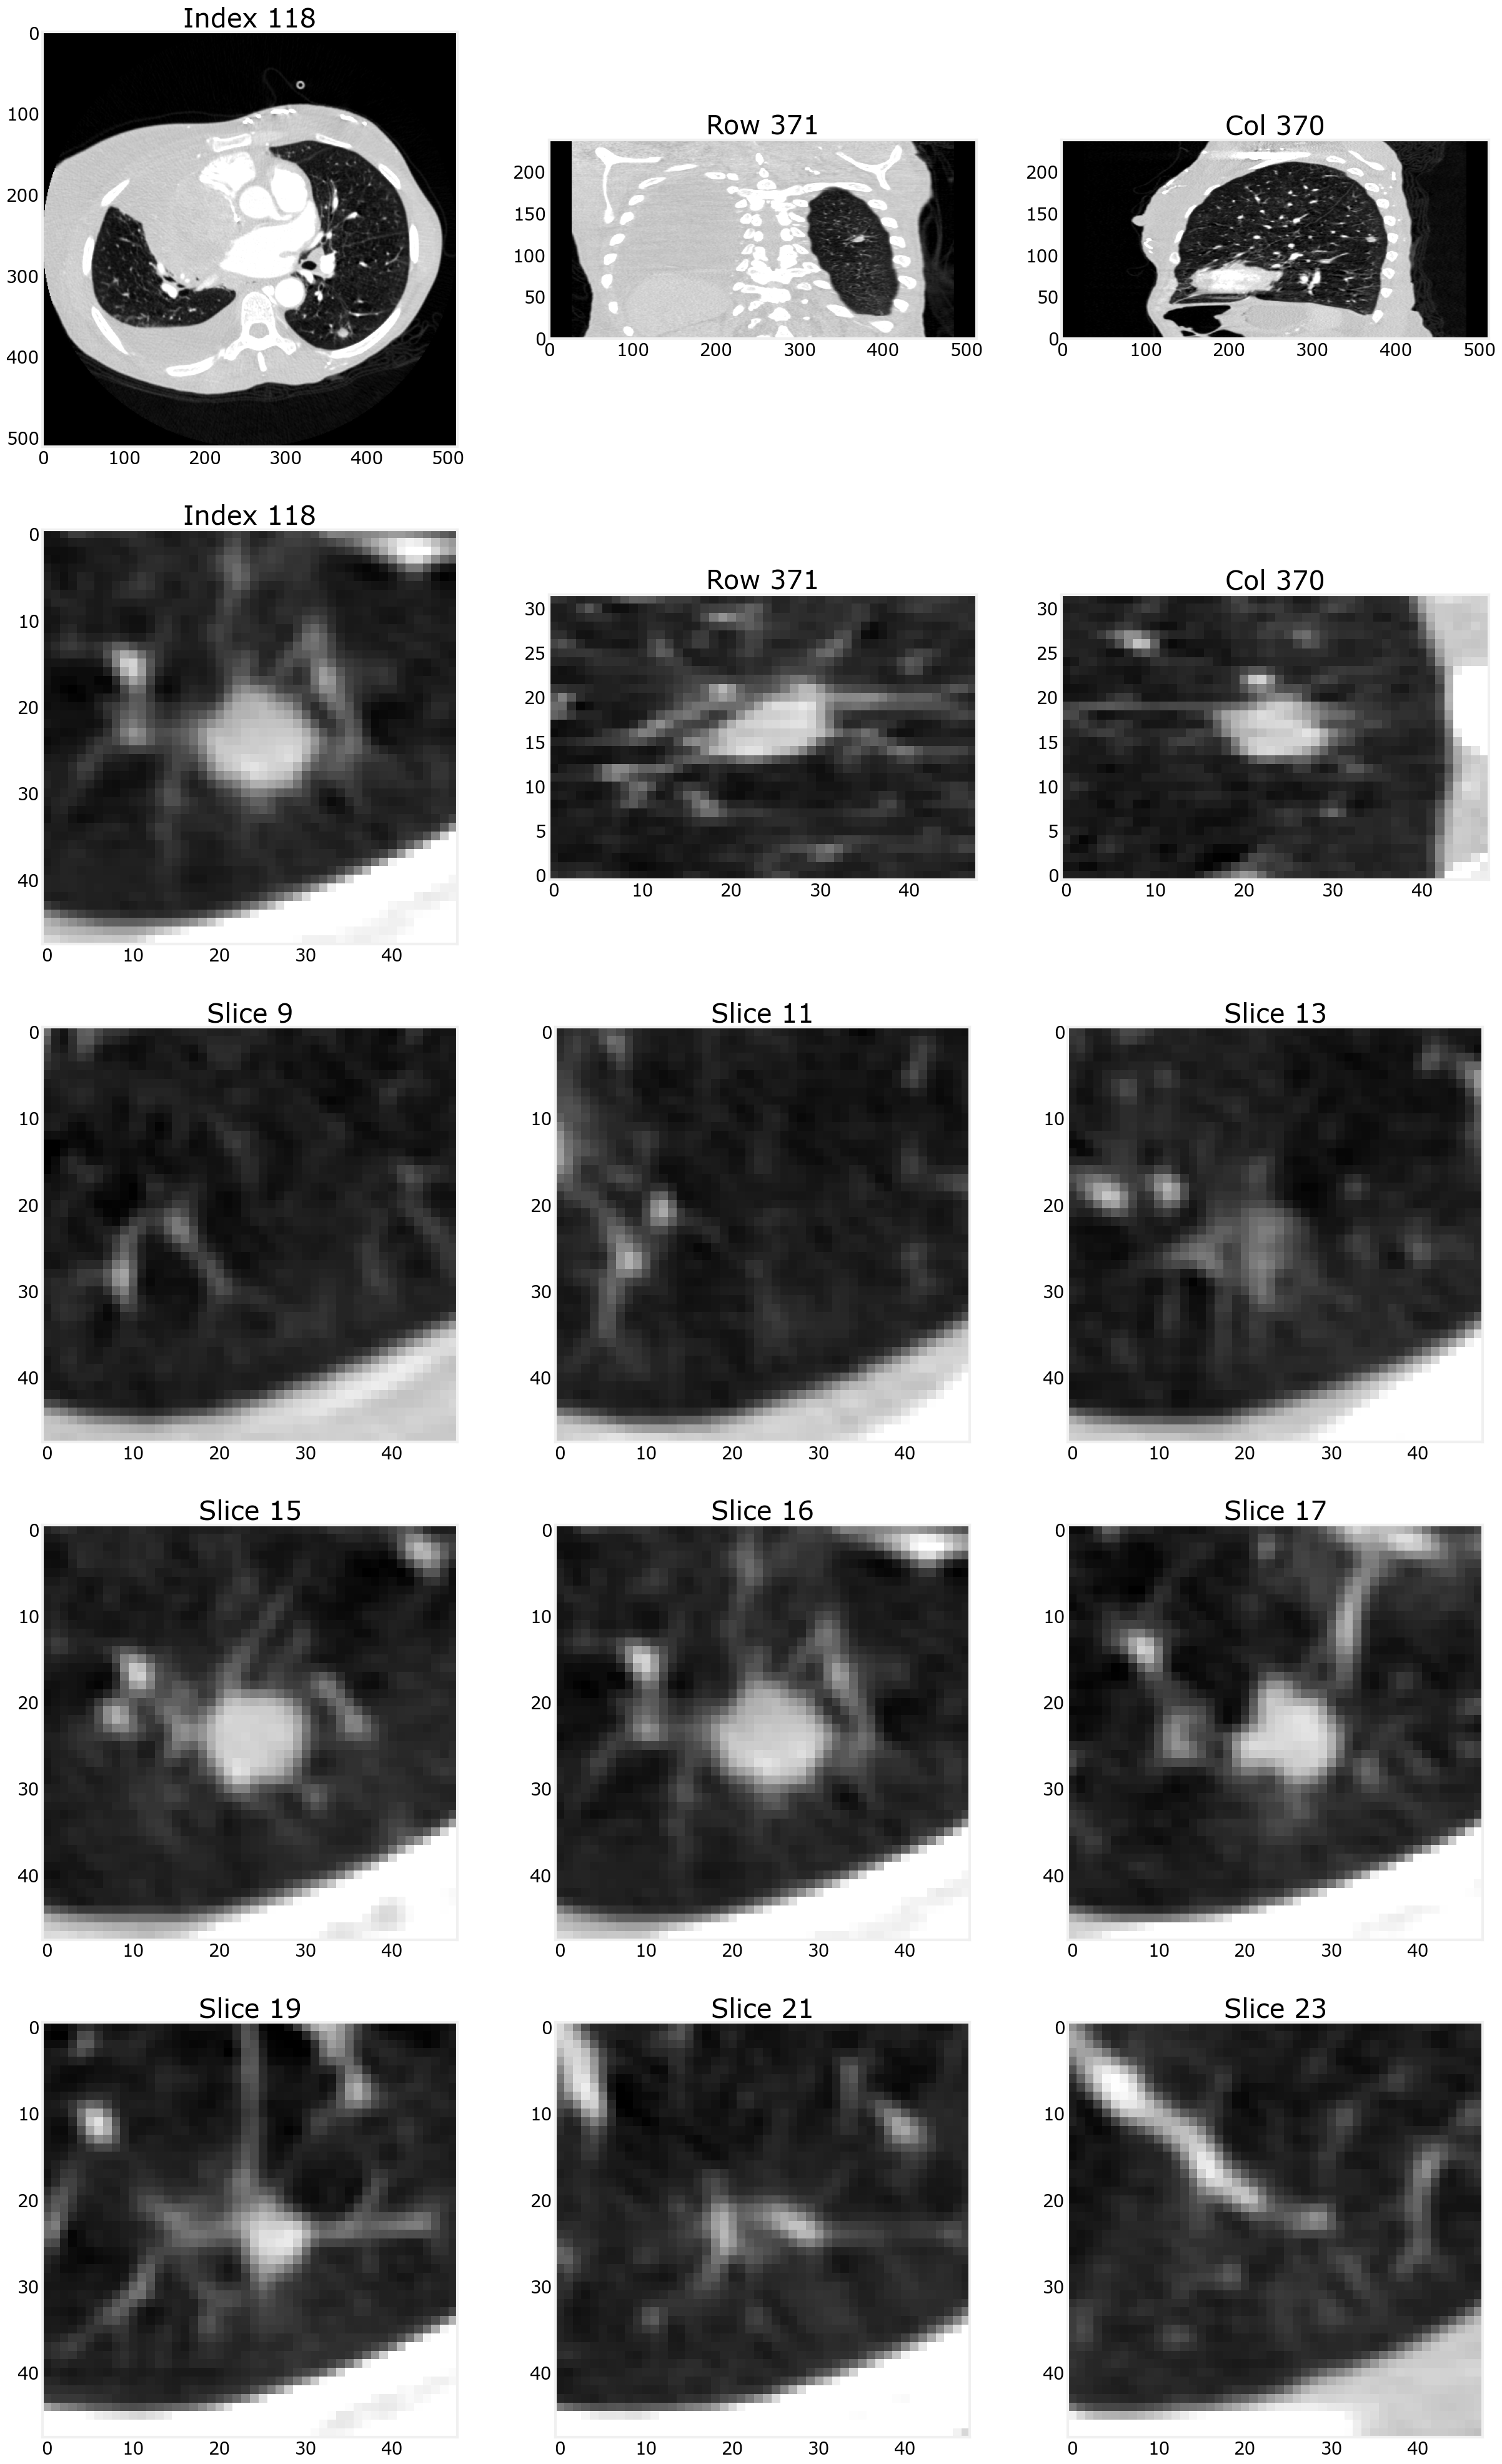

In [47]:
visualizations.show_positive_candidate()